In [115]:
import os
import random
from pathlib import Path

import ffmpeg
import math
import cv2
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchaudio
from torch.utils.data import Dataset, DataLoader, get_worker_info

from data_process.audio_process import MelSpectrogram
from get_dir import get_datasetroot, get_data_directory
from model.dataset import KablabDataset, av_speech_collate_fn_pad
from hparams import create_hparams

In [116]:
data_root = Path(get_datasetroot()).expanduser()

In [117]:
datasets = KablabDataset(data_root)
loader = DataLoader(
    dataset=datasets,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=True,
    collate_fn=av_speech_collate_fn_pad
)

Size of KablabDataset: 5


In [118]:
hparams = create_hparams()

In [120]:
fps = 50
# fps = hparams.fps
# hparams.fpsだけ認識されません…
sampling_rate = hparams.sampling_rate
n_fft = hparams.n_fft
hop_length = hparams.hop_length
win_length = hparams.win_length
f_min = hparams.f_min
f_max = hparams.f_max
n_mel_channels = hparams.n_mel_channels

# loader出力

In [121]:
for bdx, batch in enumerate(loader):
        (video, video_lengths), (speeches, audio_lengths), (melspecs, melspec_lengths, mel_gates) = batch
        
        frames = video
        print("################################################")
        print("<video_data>")
        print(f"video.shape = {video.shape}")
        print(f"video_lengths.shape = {video_lengths.shape}, video_lengths = {video_lengths}")
        print("\n<audio_data>")
        print(f"speeches.shape = {speeches.shape}")
        print(f"audio_lengths.shape = {audio_lengths.shape}, audio_lengths = {audio_lengths}")
        print(f"melspecs.shape = {melspecs.shape}")
        print(f"melspec_lengths.shape = {melspec_lengths.shape}, melspec_lengths = {melspec_lengths}")
        print(f"mel_gates.shape = {mel_gates.shape}")

################################################
<video_data>
video.shape = torch.Size([2, 3, 56, 96, 128])
video_lengths.shape = torch.Size([2]), video_lengths = tensor([46, 56])

<audio_data>
speeches.shape = torch.Size([2, 17599])
audio_lengths.shape = torch.Size([2]), audio_lengths = tensor([14399, 17599])
melspecs.shape = torch.Size([2, 80, 69])
melspec_lengths.shape = torch.Size([2]), melspec_lengths = tensor([57, 69])
mel_gates.shape = torch.Size([2, 69])
################################################
<video_data>
video.shape = torch.Size([2, 3, 47, 96, 128])
video_lengths.shape = torch.Size([2]), video_lengths = tensor([37, 47])

<audio_data>
speeches.shape = torch.Size([2, 14399])
audio_lengths.shape = torch.Size([2]), audio_lengths = tensor([11200, 14399])
melspecs.shape = torch.Size([2, 80, 57])
melspec_lengths.shape = torch.Size([2]), melspec_lengths = tensor([44, 57])
mel_gates.shape = torch.Size([2, 57])


## duration_check

In [122]:
video_duration = video.shape[2] / 50
audio_duration = speeches.shape[1] / 16000
print(video_duration)
print(audio_duration)

0.94
0.8999375


## image_check

In [123]:
B, C, T, H, W = video.shape
image = video[0, :, 0, :, :].permute(1, 2, 0).numpy()
print(video.shape)
print(image.shape)

duration = T / 50
print(duration)

torch.Size([2, 3, 47, 96, 128])
(96, 128, 3)
0.94


In [124]:
def imshow(img):
    """ndarray 配列をインラインで Notebook 上に表示する。"""
    img = transforms.functional.to_pil_image(img)
    display(img)

torch.Size([3, 47, 96, 128])
torch.Size([47, 3, 96, 128])
torch.float32


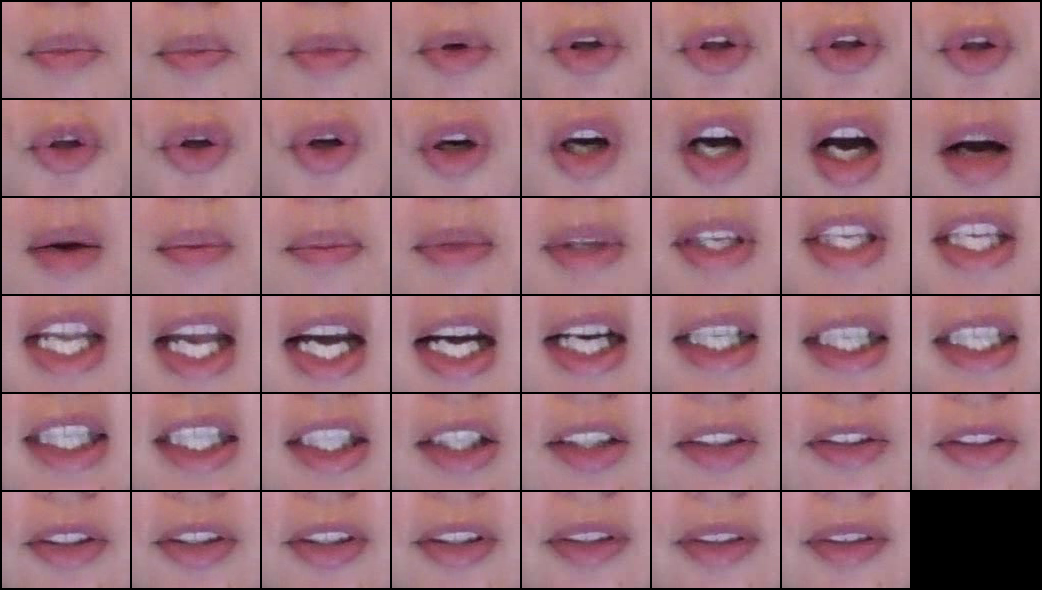

In [125]:
# 形状変換
video = video[1]
print(video.shape)
video = video.permute(1, 0, 2, 3)
print(video.shape)

# データ型変換
# floatのままだとなんか緑になる
print(video.dtype)
video = video.to(torch.uint8)

img = torchvision.utils.make_grid(video)
imshow(img)

In [126]:
datasets.items[0][0]

'/Users/minami/dataset/lip/lip_cropped/ATR503_j01_0.mp4'

In [127]:
video_path = datasets.items[0][0]
frames, _, _ = torchvision.io.read_video(video_path)
print(frames.shape)
frames = frames.permute(0, 3, 1, 2)
print(frames.dtype)
print(frames.shape)
# float()をつけると緑になっちゃう
# frames = frames.permute(0, 3, 1, 2).float()

img = torchvision.utils.make_grid(frames)
# imshow(img)

torch.Size([195, 96, 128, 3])
torch.uint8
torch.Size([195, 3, 96, 128])


In [128]:
trans = transforms.Compose([
    transforms.Lambda(lambda im: im.float() / 255.0),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [129]:
frames_trans = trans(frames)
img = torchvision.utils.make_grid(frames_trans)
# imshow(img)

## Audio_check

In [130]:
print(speeches.shape)
print(melspecs.shape)

torch.Size([2, 14399])
torch.Size([2, 80, 57])


In [131]:
speeches = speeches[0].unsqueeze(0)
print(speeches.shape)
melspecs = melspecs[0].unsqueeze(0)
print(melspecs.shape)

torch.Size([1, 14399])
torch.Size([1, 80, 57])


In [132]:
sampling_rate = 16000
duration = speeches.shape[1] / sampling_rate
print(duration)

0.8999375


In [133]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [134]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [135]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [136]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

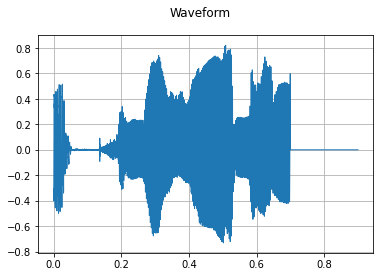

/Users/minami/Documents/python/.venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


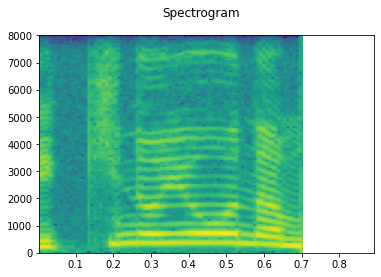

In [137]:
plot_waveform(speeches, sampling_rate)
plot_specgram(speeches, sampling_rate)

In [138]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sampling_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mel_channels,
    mel_scale="htk",
)

torch.Size([1, 80, 57])


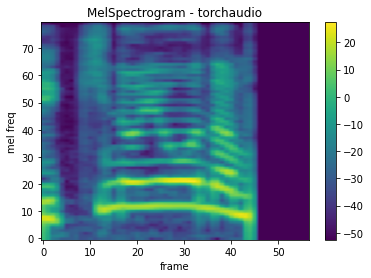

In [139]:
mel_spec_natural = mel_spectrogram(speeches)
print(mel_spec_natural.shape)
plot_spectrogram(mel_spec_natural[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

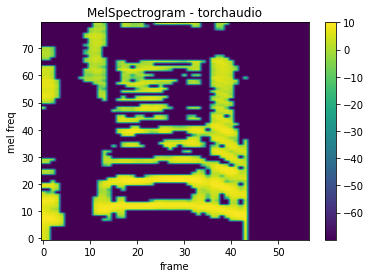

In [140]:
# 正規化の影響
plot_spectrogram(melspecs[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")